In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

print([np.__version__, pd.__version__])
np.set_printoptions(precision=3, suppress=True)


from src.data_preprocessing import preprocess_data
from src.plotting import plot_heatmap
from src.causal_matrix_evaluation import evaluate_causal_matrices
from src.run_causal_discovery import run_varlingam, run_pcmci, run_varlingam_bootstrap
from src.rcv_varlingam import run_rcv_varlingam
from src.rcv_pcmci import run_rcv_pcmci

['1.24.4', '2.0.3']


In [2]:
def ground_truth_to_matrices(csv_path):
    # Read the CSV file
    with open(csv_path, 'r') as f:
        content = f.read()

    # Split the content by double newlines to separate matrices
    matrix_strings = content.strip().split('\n\n')
    
    # Convert each matrix string to a numpy array
    matrices = []
    for matrix_string in matrix_strings:
        matrix = np.array([list(map(float, row.split(','))) for row in matrix_string.split('\n')])
        matrices.append(matrix)
    
    return matrices

# Function to load ground truth
def load_ground_truth(data_type):
    ground_truth_path = f'data/synthetic/{data_type}/ground_truth.csv'
    try:
        return ground_truth_to_matrices(ground_truth_path)
    except FileNotFoundError:
        print(f"Ground truth file not found: {ground_truth_path}")
        return None

def save_adjacency_matrices_to_results(B_matrices, filepath):
    with open(filepath, 'w') as f:
        for i, B in enumerate(B_matrices):
            np.savetxt(f, B, delimiter=',', fmt='%.3f')
            if i < len(B_matrices) - 1:
                f.write('\n')

In [18]:
def run_experiment(data_type, n_datasets=10):
    methods = ['varlingam', 'pcmci', 'rcv_varlingam', 'rcv_pcmci', 'varlingam_bootstrap']
    
    # Load ground truth for this data type
    ground_truth_matrices = load_ground_truth(data_type)
    if ground_truth_matrices is None:
        print(f"Skipping experiments for {data_type} due to missing ground truth")
        return
    
    for method in methods:
        results = []
        
        for i in range(n_datasets):
            # Load data
            data = pd.read_csv(f'data/synthetic/{data_type}/dataset_{i}.csv')
            columns = data.columns.tolist()
            if "Date" in columns:
                data = data.drop(['Date'], axis=1).values
                columns.remove('Date')
            elif "timestamp" in columns:
                data = data.drop(['timestamp'], axis=1).values
                columns.remove('timestamp')
            else:
                data = data.values
            
            print(f"Running {method} on dataset {i} of type {data_type}")
            
            # Preprocess data
            data = preprocess_data(data, columns)
            
            # Run causal discovery method
            start_time = time.time()
            
            if method == 'varlingam':
                result = run_varlingam(data)
                adjacency_matrices = result.adjacency_matrices_
            elif method == 'pcmci':
                adjacency_matrices = run_pcmci(data, columns)
            elif method == 'rcv_varlingam':
                adjacency_matrices = run_rcv_varlingam(data)
            elif method == 'rcv_pcmci':
                adjacency_matrices = run_rcv_pcmci(data)
            elif method == 'varlingam_bootstrap':
                adjacency_matrices = run_varlingam_bootstrap(data)
            
            end_time = time.time()
            runtime = round(end_time - start_time, 4)
            
            # Plot and store the estimated adjacency matrices of the first dataset
            if i == 0:
                if len(adjacency_matrices) > len(ground_truth_matrices):
                    adjacency_matrices_save = adjacency_matrices[:len(ground_truth_matrices)]
                else:
                    adjacency_matrices_save = adjacency_matrices
                plot_heatmap(adjacency_matrices_save, columns, title=f"Heatmap of Adjacency Matrices from {method}")
                output_file = f'results/synthetic/{data_type}/adj_matrices_{method}.csv'
                save_adjacency_matrices_to_results(adjacency_matrices_save, output_file)
            # Evaluate results
            evaluation = evaluate_causal_matrices(ground_truth_matrices, adjacency_matrices)
            
            # Store results
            results.append({
                'dataset': f'dataset_{i}',
                'SHD': evaluation['shd'],
                'F1': evaluation['f1'],
                'F1_directed': evaluation['f1_directed'],
                'Frobenius': evaluation['fro'],
                'runtime': runtime
            })
        
        # Calculate average and standard deviation
        avg_result = {
            'dataset': 'Overall Average',
            'Frobenius': f"{np.mean([r['Frobenius'] for r in results]):.3f} ± {np.std([r['Frobenius'] for r in results], ddof=1):.3f}",
            'SHD': f"{np.mean([r['SHD'] for r in results]):.2f} ± {np.std([r['SHD'] for r in results], ddof=1):.2f}",
            'F1': f"{np.mean([r['F1'] for r in results]):.3f} ± {np.std([r['F1'] for r in results], ddof=1):.3f}",
            'F1_directed': f"{np.mean([r['F1_directed'] for r in results]):.3f} ± {np.std([r['F1_directed'] for r in results], ddof=1):.3f}",
            'runtime': f"{np.mean([r['runtime'] for r in results]):.4f}"
        }
        results.append(avg_result)
        
        # Save results to CSV
        df_results = pd.DataFrame(results)
        df_results.to_csv(f'results/synthetic/{data_type}/performance_{method}.csv', index=False)

Running experiments for non_stationary data...
Running varlingam on dataset 0 of type non_stationary


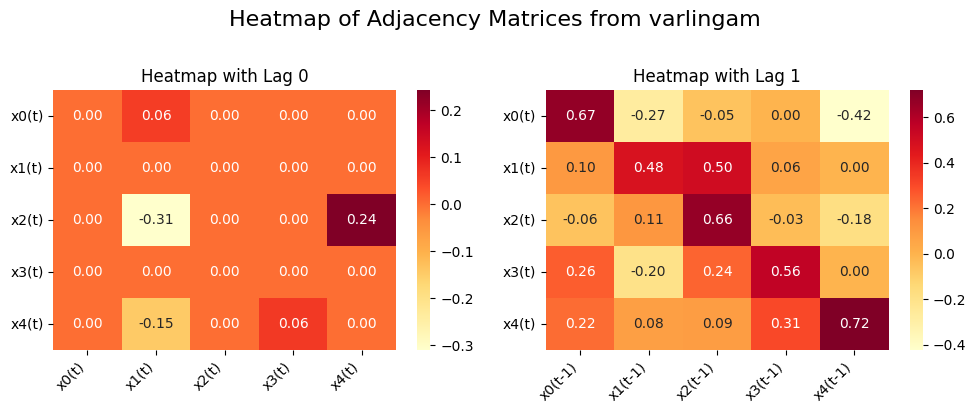

Running varlingam on dataset 1 of type non_stationary
Running varlingam on dataset 2 of type non_stationary
Running varlingam on dataset 3 of type non_stationary
Running varlingam on dataset 4 of type non_stationary
Running varlingam on dataset 5 of type non_stationary
Running varlingam on dataset 6 of type non_stationary
Running varlingam on dataset 7 of type non_stationary
Running varlingam on dataset 8 of type non_stationary
Running varlingam on dataset 9 of type non_stationary
Running pcmci on dataset 0 of type non_stationary

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable x0 has 6 link(s):
        (x0 -1): max_pval = 0.00000, |min_val| =  0.665
        (x4 -1): max_pval = 0.00000, |min_val| =  0.184
        (x0 -3): max_pval = 0.00000, |min_val| =  0.177
        (x2 -2): max_pval = 0.0

<Figure size 640x480 with 0 Axes>

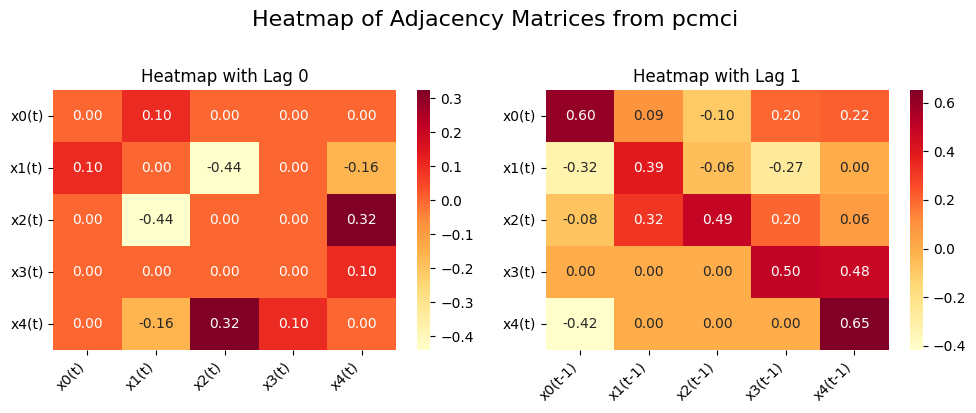

Running pcmci on dataset 1 of type non_stationary

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable x0 has 6 link(s):
        (x0 -1): max_pval = 0.00000, |min_val| =  0.641
        (x4 -3): max_pval = 0.00000, |min_val| =  0.233
        (x1 -1): max_pval = 0.00000, |min_val| =  0.161
        (x1 -3): max_pval = 0.00016, |min_val| =  0.120
        (x4 -2): max_pval = 0.00062, |min_val| =  0.109
        (x2 -3): max_pval = 0.00301, |min_val| =  0.094

    Variable x1 has 5 link(s):
        (x1 -1): max_pval = 0.00000, |min_val| =  0.559
        (x2 -1): max_pval = 0.00000, |min_val| =  0.259
        (x1 -3): max_pval = 0.00000, |min_val| =  0.208
        (x1 -2): max_pval = 0.00091, |min_val| =  0.105
        (x3 -3): max_pval = 0.02179, |min_val| =  0.073

    Variable x2 has 4 link(s):
     

<Figure size 640x480 with 0 Axes>

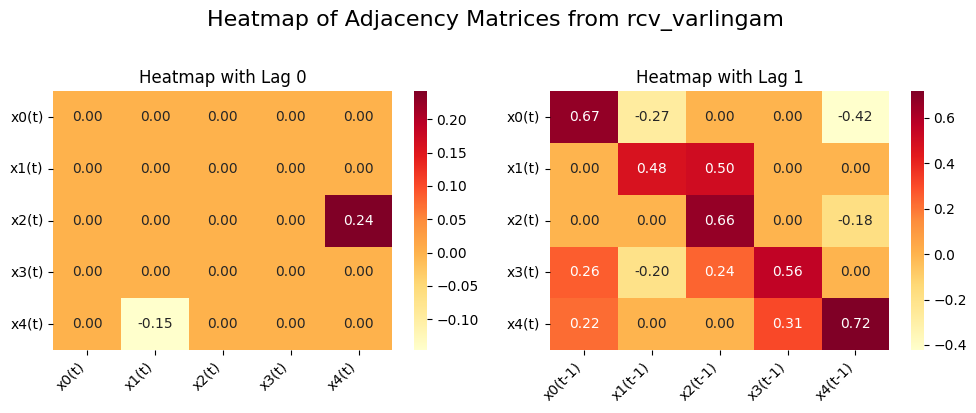

Running rcv_varlingam on dataset 1 of type non_stationary
Running rcv_varlingam on dataset 2 of type non_stationary
Running rcv_varlingam on dataset 3 of type non_stationary
Running rcv_varlingam on dataset 4 of type non_stationary
Running rcv_varlingam on dataset 5 of type non_stationary
Running rcv_varlingam on dataset 6 of type non_stationary
Running rcv_varlingam on dataset 7 of type non_stationary
Running rcv_varlingam on dataset 8 of type non_stationary
Running rcv_varlingam on dataset 9 of type non_stationary
Running rcv_pcmci on dataset 0 of type non_stationary

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 6 link(s):
        (0 -1): max_pval = 0.00000, |min_val| =  0.665
        (4 -1): max_pval = 0.00000, |min_val| =  0.184
        (0 -3): max_pval = 0.00000, |min_val| =  0

<Figure size 640x480 with 0 Axes>

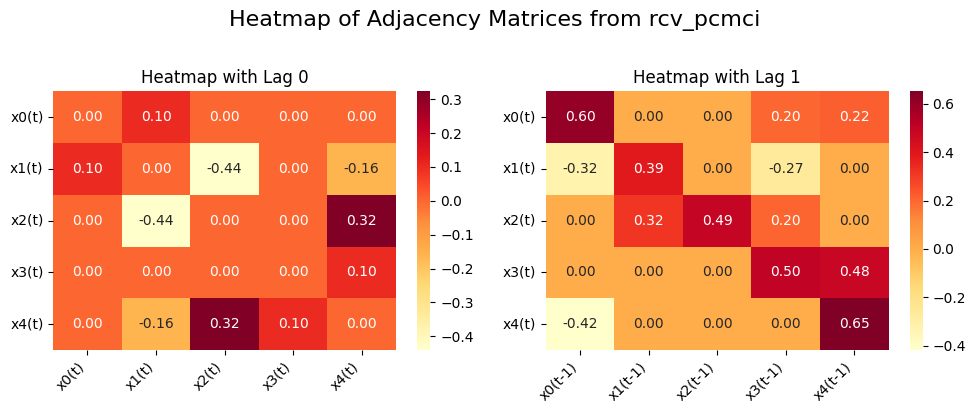

Running rcv_pcmci on dataset 1 of type non_stationary

##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 3
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable 0 has 6 link(s):
        (0 -1): max_pval = 0.00000, |min_val| =  0.641
        (4 -3): max_pval = 0.00000, |min_val| =  0.233
        (1 -1): max_pval = 0.00000, |min_val| =  0.161
        (1 -3): max_pval = 0.00016, |min_val| =  0.120
        (4 -2): max_pval = 0.00062, |min_val| =  0.109
        (2 -3): max_pval = 0.00301, |min_val| =  0.094

    Variable 1 has 5 link(s):
        (1 -1): max_pval = 0.00000, |min_val| =  0.559
        (2 -1): max_pval = 0.00000, |min_val| =  0.259
        (1 -3): max_pval = 0.00000, |min_val| =  0.208
        (1 -2): max_pval = 0.00091, |min_val| =  0.105
        (3 -3): max_pval = 0.02179, |min_val| =  0.073

    Variable 2 has 4 link(s):
        (2 -1):

<Figure size 640x480 with 0 Axes>

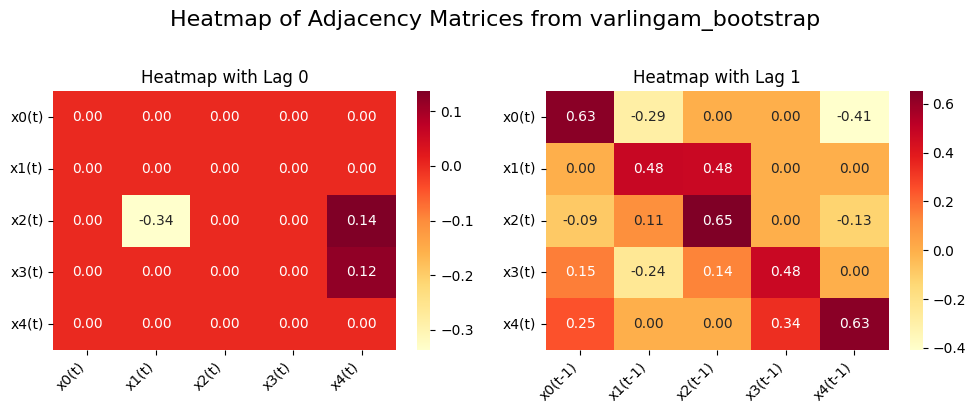

Running varlingam_bootstrap on dataset 1 of type non_stationary
Running varlingam_bootstrap on dataset 2 of type non_stationary
Running varlingam_bootstrap on dataset 3 of type non_stationary
Running varlingam_bootstrap on dataset 4 of type non_stationary
Running varlingam_bootstrap on dataset 5 of type non_stationary
Running varlingam_bootstrap on dataset 6 of type non_stationary
Running varlingam_bootstrap on dataset 7 of type non_stationary
Running varlingam_bootstrap on dataset 8 of type non_stationary
Running varlingam_bootstrap on dataset 9 of type non_stationary
All experiments completed.


<Figure size 640x480 with 0 Axes>

In [22]:
# Run experiments for different data types
data_types = ['linear', 'non_linear', 
              'gaussian', 'non_gaussian', 
              'stationary', 'non_stationary', 
              'sparse', 'dense',
              'scale_250_length', 'scale_1000_length', 'scale_2000_length',
              'scale_5_var', 'scale_20_var', # ['scale_50_var']
]

# data_types = ['scale_5_var']
for data_type in data_types:
    print(f"Running experiments for {data_type} data...")
    run_experiment(data_type, n_datasets=10)

print("All experiments completed.")

# Plotting the figures for the final report

### 1. Generate the performance bar charts for different pairs of characteristics

Figure saved to results/synthetic/_figures/shd_scale_5_var_scale_20_var_scale_50_var.png
Figure saved to results/synthetic/_figures/f1_scale_5_var_scale_20_var_scale_50_var.png
Figure saved to results/synthetic/_figures/f1_directed_scale_5_var_scale_20_var_scale_50_var.png
Figure saved to results/synthetic/_figures/frobenius_scale_5_var_scale_20_var_scale_50_var.png


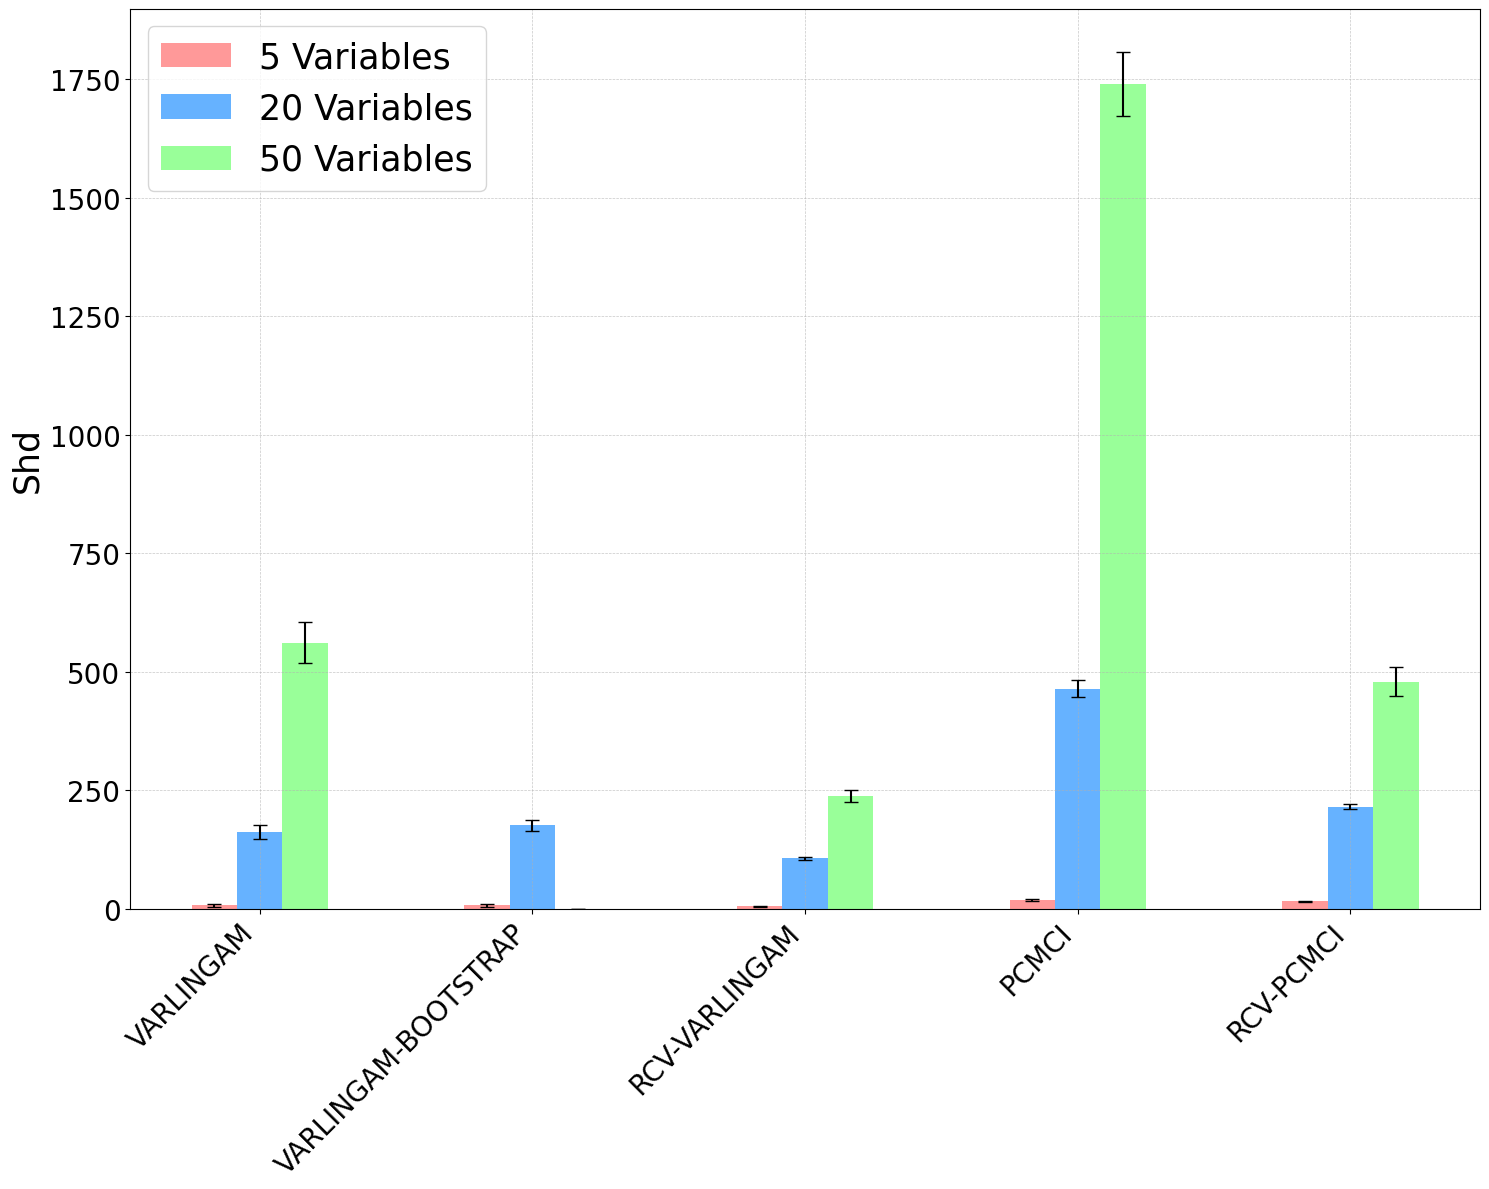

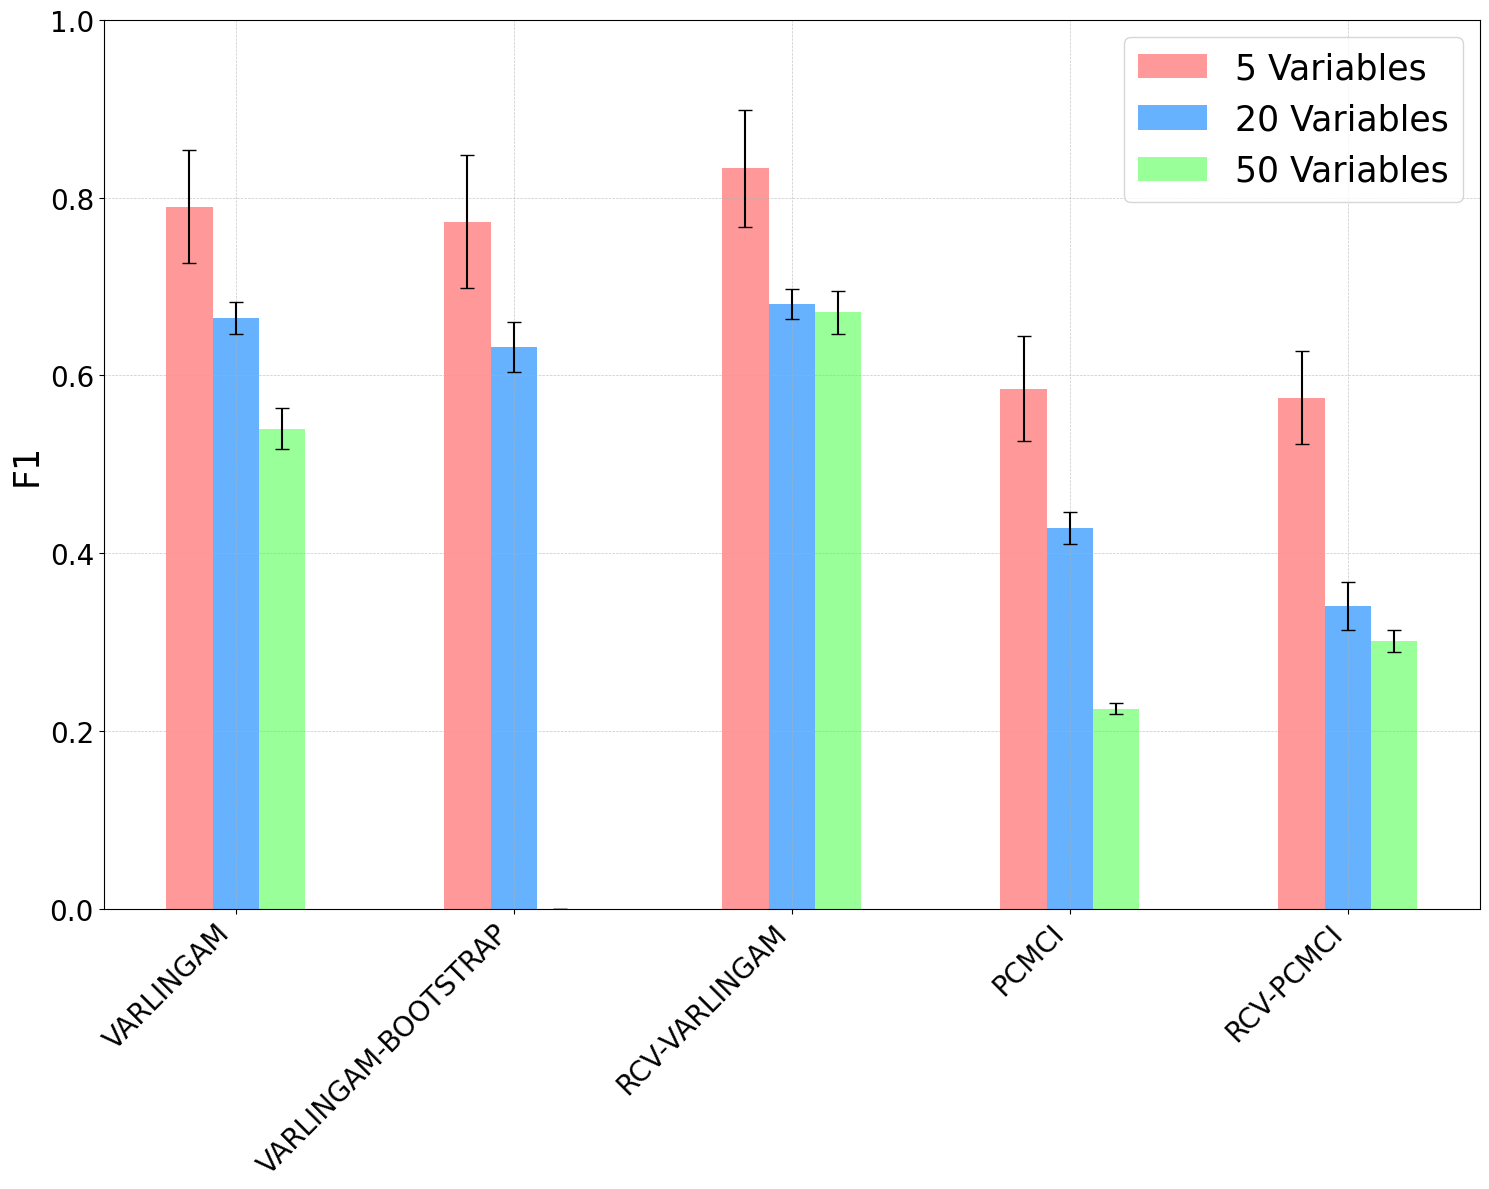

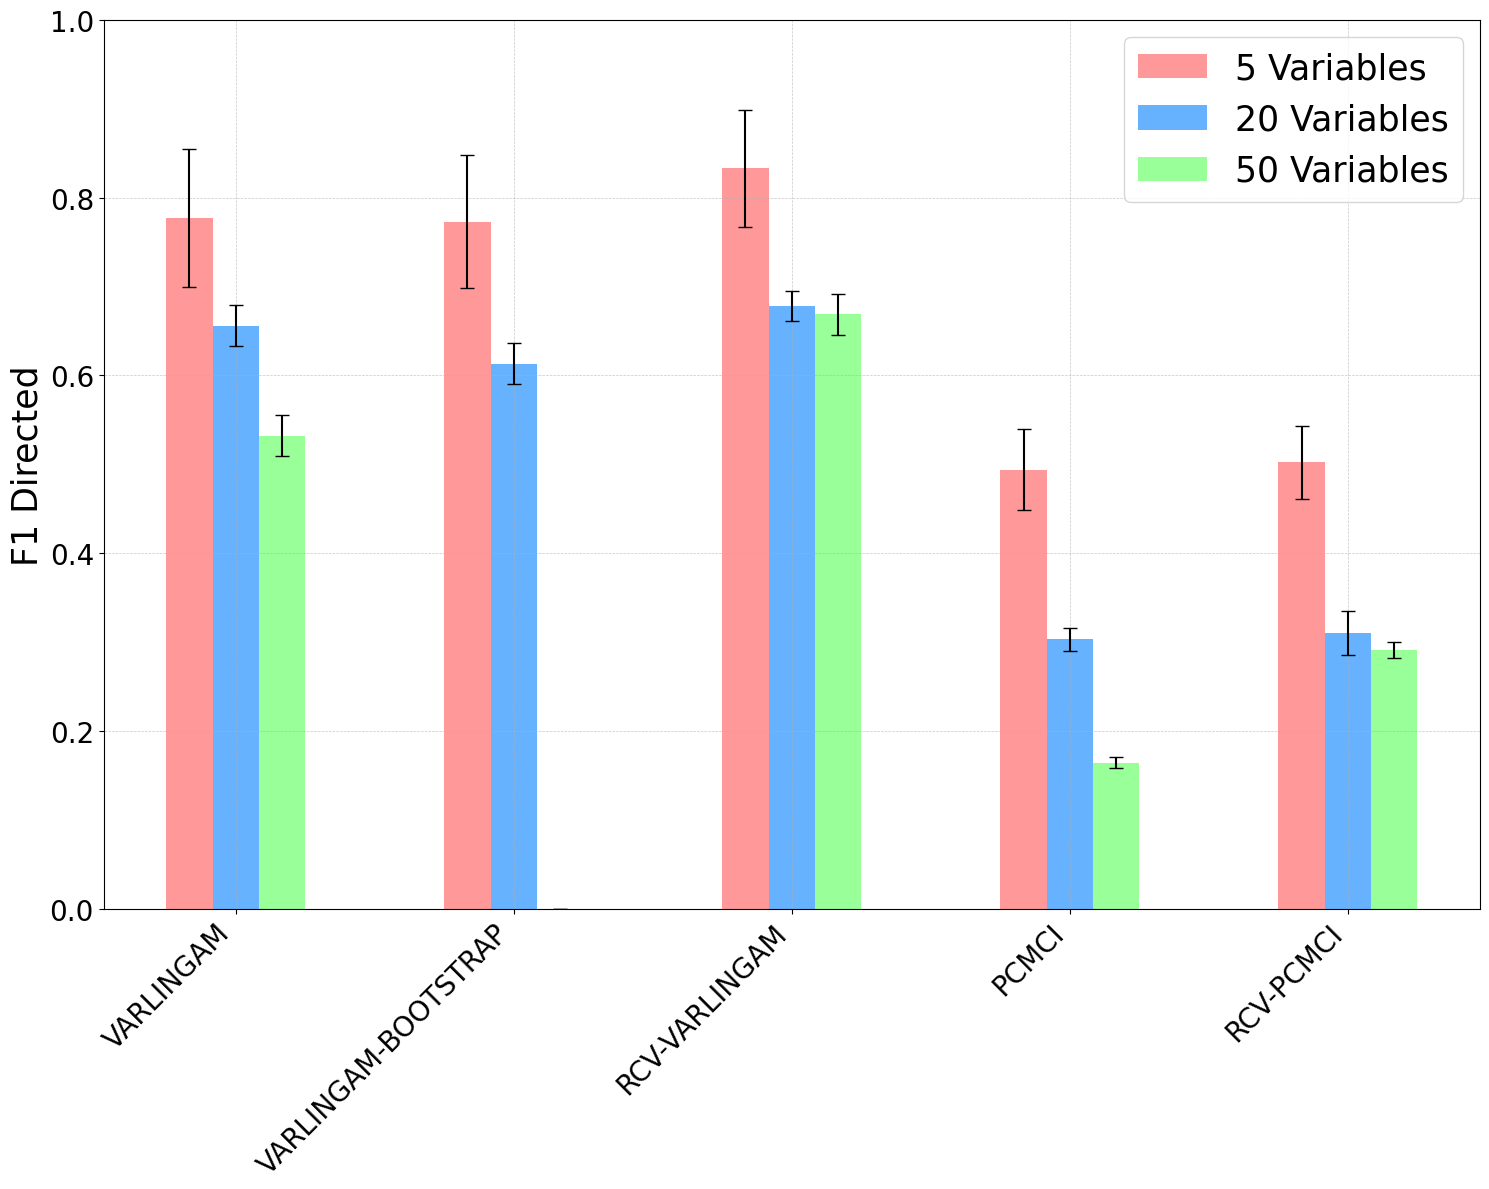

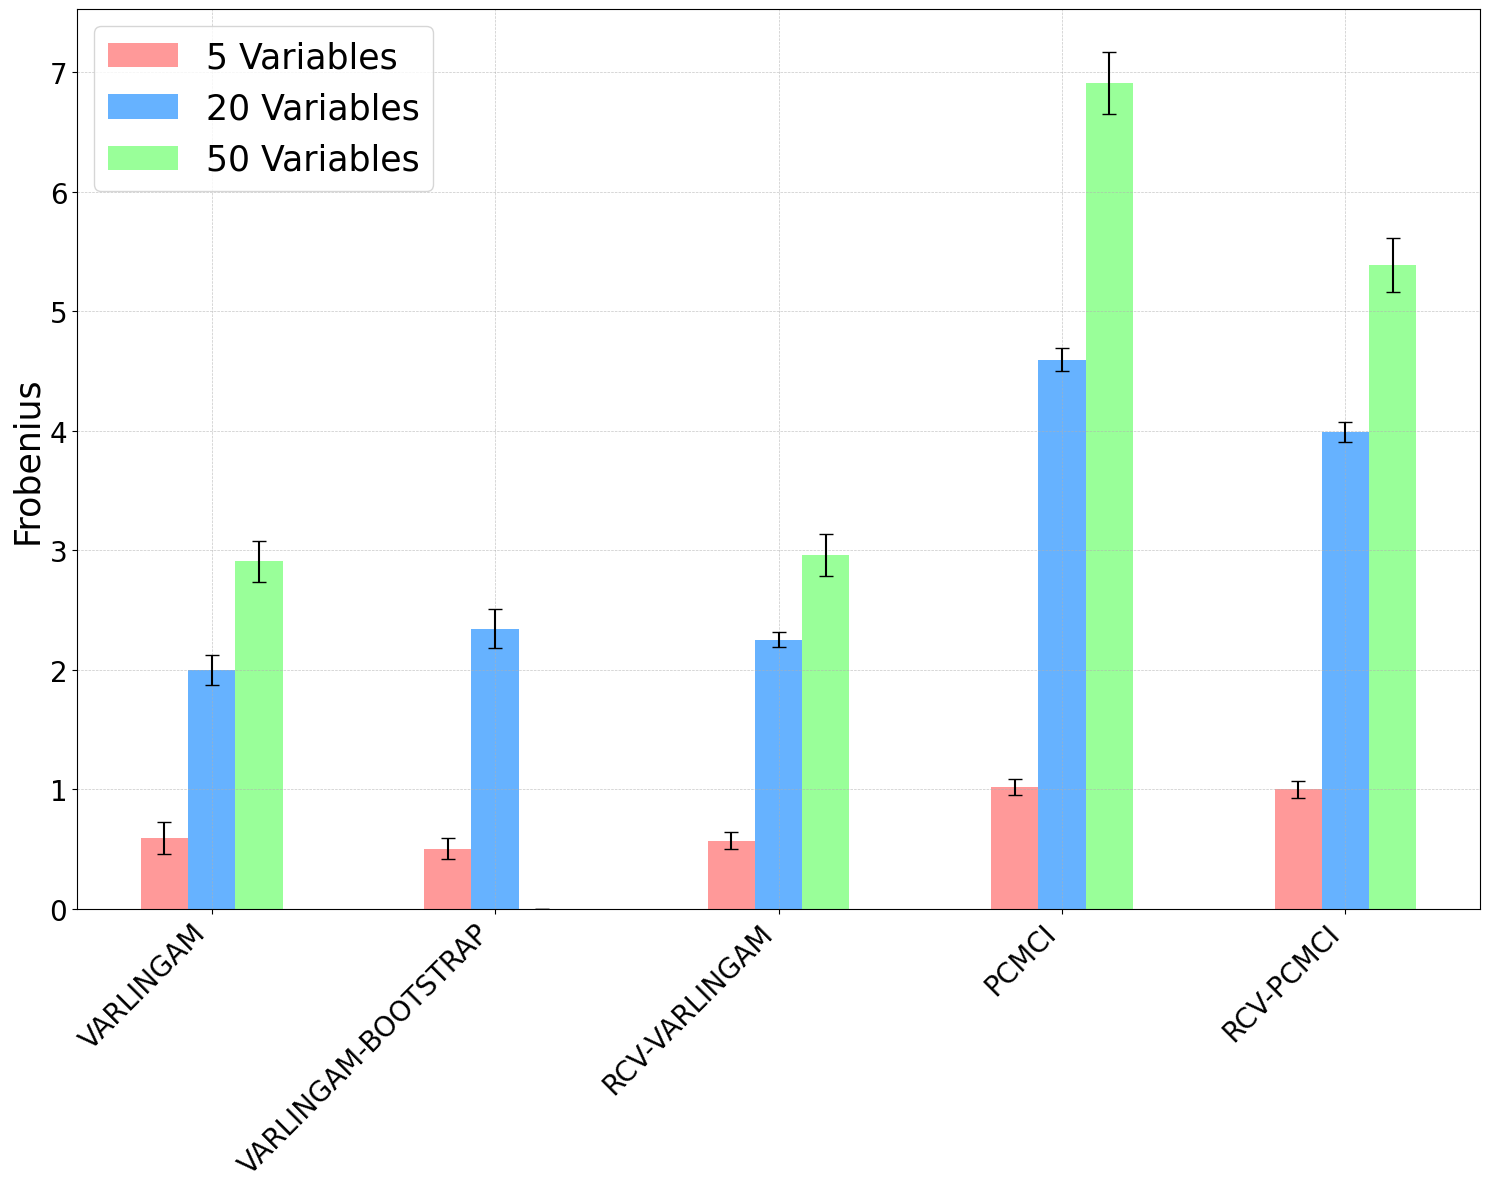

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def extract_metric_score(file_path, metric):
    try:
        df = pd.read_csv(file_path)
        overall_average = df[df['dataset'] == 'Overall Average']
        if overall_average.empty:
            return (0.00, 0.00)
        score = overall_average[metric].values[0]
        mean, std = map(float, score.split('±'))
        return (mean, std)
    except FileNotFoundError:
        print(f"Warning: File not found - {file_path}")
        return (0.00, 0.00)

def collect_data(dataset_types, metric):
    data = {}
    methods = ['varlingam', 'varlingam_bootstrap', 'rcv_varlingam', 'pcmci', 'rcv_pcmci']
    for dataset_type in dataset_types:
        type_data = {}
        for method in methods:
            file_path = f'results/synthetic/{dataset_type}/performance_{method}.csv'
            type_data[method] = extract_metric_score(file_path, metric)
        data[dataset_type] = type_data
    return data

def plot_performance_comparison(dataset_types, metric='F1_directed', save_path=None):
    
    data = collect_data(dataset_types, metric)
    methods = ['varlingam', 'varlingam_bootstrap', 'rcv_varlingam', 'pcmci', 'rcv_pcmci']
    
    plt.figure(figsize=(15, 12))
    x = np.arange(len(methods))
    width = 0.5 / len(dataset_types)

    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC', '#99CCFF']
    colors = colors[:len(dataset_types)]  # Use only the first few colors

    for i, (dataset_type, type_data) in enumerate(data.items()):
        means = [type_data[m][0] for m in methods]
        stds = [type_data[m][1] for m in methods]
        plt.bar(x + (i - len(dataset_types)/2 + 0.5) * width, means, width, 
                label=dataset_type.replace('_', ' ').title(), color=colors[i], yerr=stds, capsize=5)
        # plt.bar(x + (i - len(dataset_types)/2 + 0.5) * width, means, width, 
        #         label=dataset_type.replace('scale_', '').replace('_var', ' variables').title(), color=colors[i], yerr=stds, capsize=5)
        # plt.bar(x + (i - len(dataset_types)/2 + 0.5) * width, means, width, 
        #         label=dataset_type.replace('scale_', 'series length = ').replace('_length', '').title(), color=colors[i], yerr=stds, capsize=5)

    # plt.xlabel('Method', fontsize=25)
    plt.ylabel(metric.replace('_', ' ').title(), fontsize=25)
    plt.xticks(x, [m.replace('_', '-').upper() for m in methods], rotation=45, ha='right', fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=25)

    if metric.lower() in ['f1', 'f1_directed']:
        plt.ylim(0, 1)
    plt.tight_layout()
    plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    else:
        plt.show()

# Plot performance comparison for different metrics
def generate_plots(dataset1, dataset2, dataset3=None):
    metrics = ['SHD', 'F1', 'F1_directed', 'Frobenius']
    for metric in metrics:
        if dataset3:
            comparison_name = f'{dataset1}_{dataset2}_{dataset3}'
        else:
            comparison_name = f'{dataset1}_{dataset2}'
        
        save_path = f'results/synthetic/_figures/{metric.lower()}_{comparison_name}.png'
        
        if dataset3:
            plot_performance_comparison([dataset1, dataset2, dataset3], metric=metric, save_path=save_path)
        else:
            plot_performance_comparison([dataset1, dataset2], metric=metric, save_path=save_path)


# Compare linear and non_linear
generate_plots('linear', 'non_linear')

# Compare gaussian and non_gaussian
generate_plots('gaussian', 'non_gaussian')

# Compare stationary and non_stationary
generate_plots('stationary', 'non_stationary')

# Compare sparse and dense
generate_plots('sparse', 'dense')

# # Compare different scales
# generate_plots('scale_5_var', 'scale_20_var', 'scale_50_var')
# generate_plots('scale_250_length', 'scale_1000_length', 'scale_2000_length')


### 2. Generate the performance bar charts for different scales

Figure saved to results/synthetic/_figures/runtime_comparison_variables.png


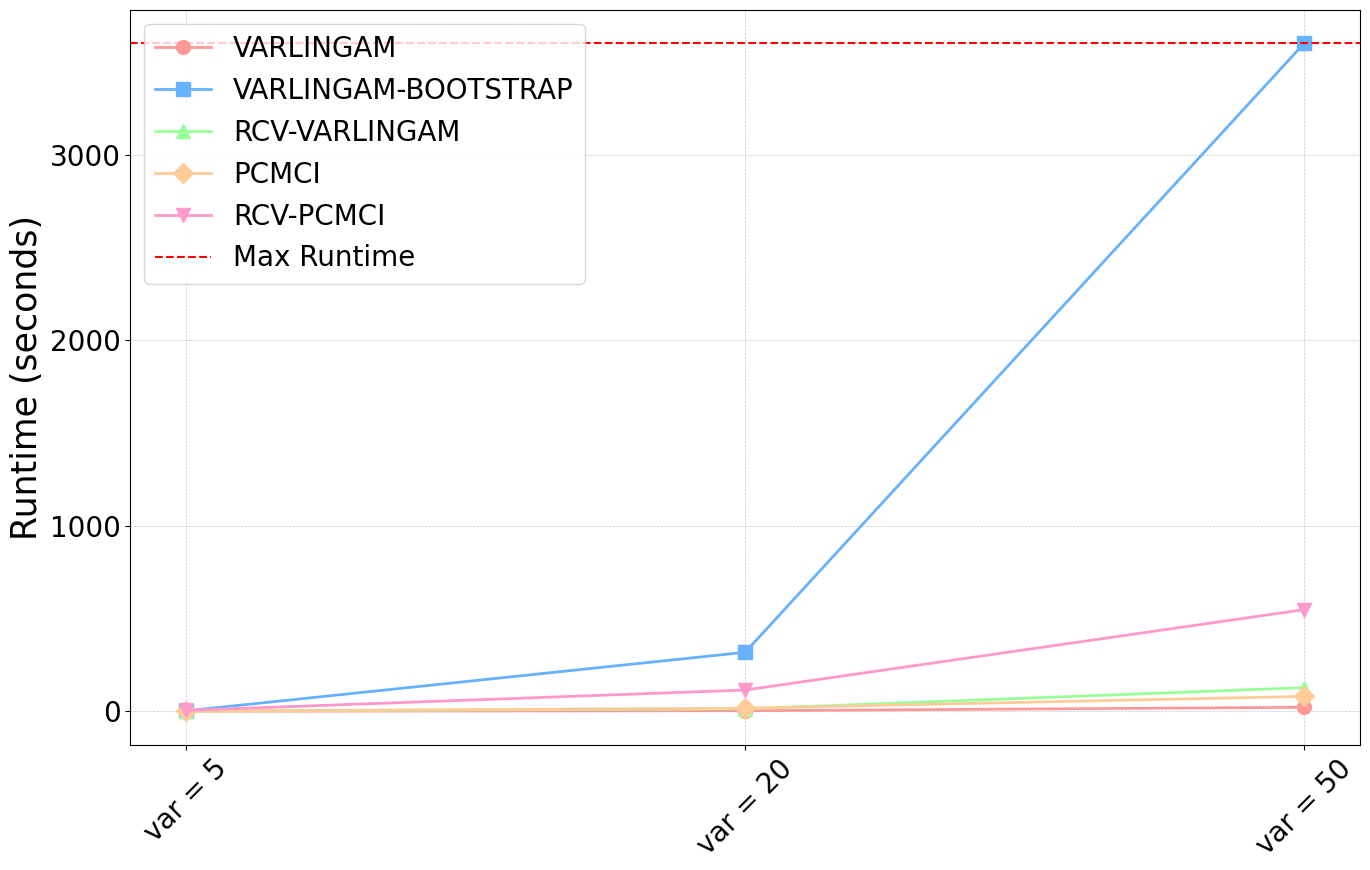

Figure saved to results/synthetic/_figures/runtime_comparison_length.png


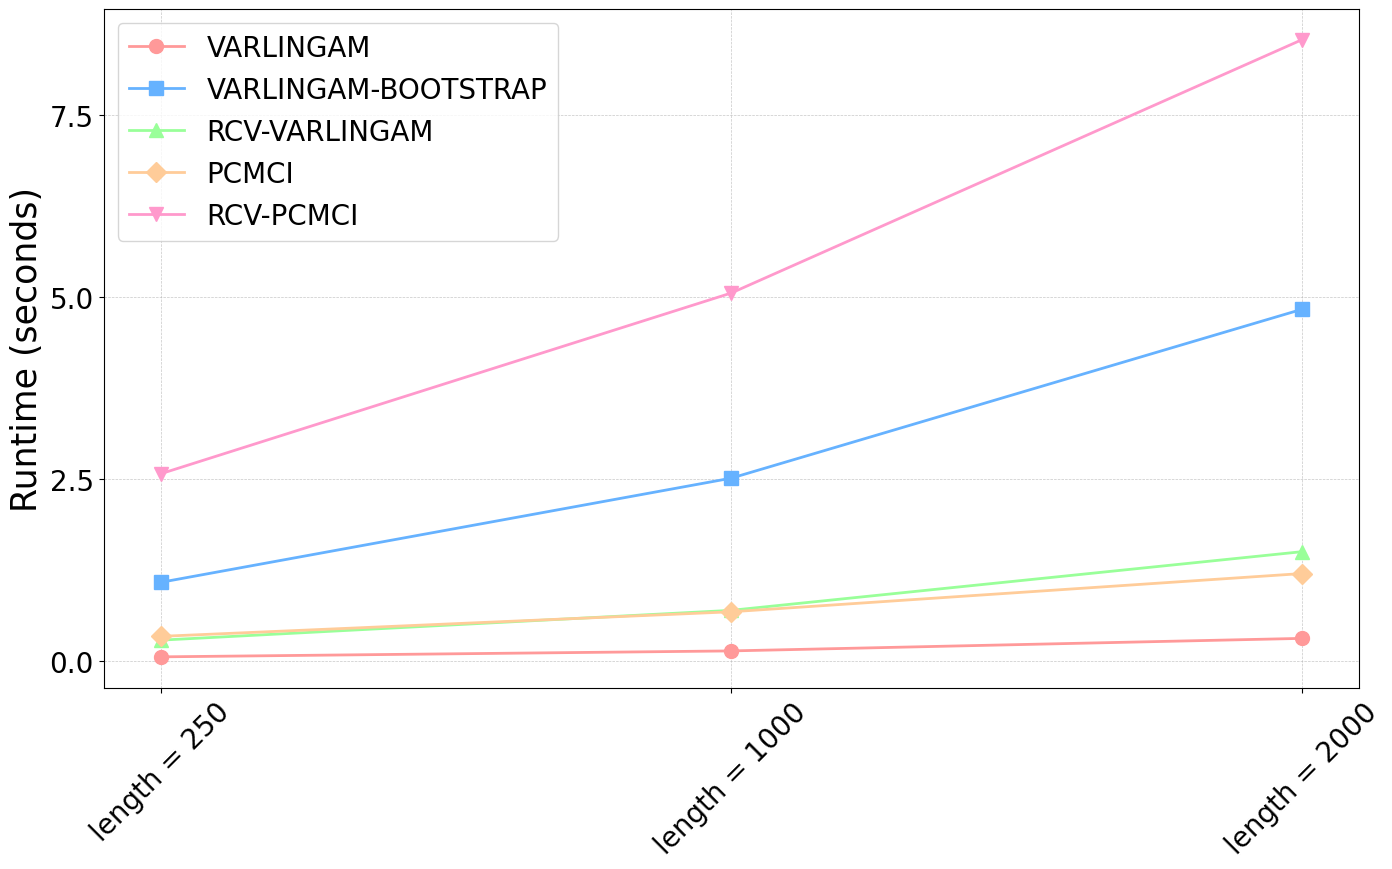

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

MAX_RUNTIME = 3600  # Set maximum runtime to 3600 seconds

def extract_runtime(file_path):
    try:
        df = pd.read_csv(file_path)
        overall_average = df[df['dataset'] == 'Overall Average']
        if overall_average.empty:
            return MAX_RUNTIME
        runtime = overall_average['runtime'].values[0]
        return min(float(runtime), MAX_RUNTIME)
    except FileNotFoundError:
        print(f"Warning: File not found - {file_path}")
        return MAX_RUNTIME

def collect_runtime_data(dataset_types):
    data = {}
    methods = ['varlingam', 'varlingam_bootstrap', 'rcv_varlingam', 'pcmci', 'rcv_pcmci']
    for method in methods:
        method_data = []
        for dataset_type in dataset_types:
            file_path = f'results/synthetic/{dataset_type}/performance_{method}.csv'
            method_data.append(extract_runtime(file_path))
        data[method] = method_data
    return data

def plot_runtime_comparison(dataset_types, save_path=None, is_var_scale=True):
    data = collect_runtime_data(dataset_types)
    methods = ['varlingam', 'varlingam_bootstrap', 'rcv_varlingam', 'pcmci', 'rcv_pcmci']
    
    plt.figure(figsize=(15, 10))
    
    markers = ['o', 's', '^', 'D', 'v']
    colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99', '#FF99CC']
    
    max_runtime_reached = False
    for i, method in enumerate(methods):
        plt.plot(range(len(dataset_types)), data[method], marker=markers[i], color=colors[i], 
                linewidth=2, markersize=10, label=method.replace('_', '-').upper())
        if MAX_RUNTIME in data[method]:
            max_runtime_reached = True
    
    # Add horizontal line indicating maximum runtime only if it's reached
    if max_runtime_reached:
        plt.axhline(y=MAX_RUNTIME, color='r', linestyle='--', label='Max Runtime')
    
    # plt.xlabel('Dataset Scale', fontsize=25)
    plt.ylabel('Runtime (seconds)', fontsize=25)
    # plt.title('Runtime Comparison Across Different Dataset Scales', fontsize=30)
    
    # Set x-axis labels based on scale type
    if is_var_scale:
        plt.xticks(range(len(dataset_types)), [f'var = {s.split("_")[1]}' for s in dataset_types], fontsize=20, rotation=45)
    else:
        plt.xticks(range(len(dataset_types)), [f'length = {s.split("_")[1]}' for s in dataset_types], fontsize=20, rotation=45)
    
    plt.yticks(fontsize=20)
    plt.legend(fontsize=20, loc='upper left')
    
    # plt.yscale('log')  # Use logarithmic scale for y-axis
    
    plt.grid(True, linestyle='--', alpha=0.7, linewidth=0.5)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()

# Use the function
scales_var = ['scale_5_var', 'scale_20_var', 'scale_50_var']
scales_length = ['scale_250_length', 'scale_1000_length', 'scale_2000_length']

plot_runtime_comparison(scales_var, save_path='results/synthetic/_figures/runtime_comparison_variables.png', is_var_scale=True)
plot_runtime_comparison(scales_length, save_path='results/synthetic/_figures/runtime_comparison_length.png', is_var_scale=False)